# LBM-CaImAn Pipeline Demo

This notebook demonstrates the new unified pipeline API for processing calcium imaging data with CaImAn.

In [54]:
import lbm_caiman_python as lcp
from mbo_utilities import imread
import numpy as np
from pathlib import Path

print(f"lbm_caiman_python version: {lcp.__version__}")

lbm_caiman_python version: 0.1.0


## 1. Setup Paths

Set your input data path and output directory.

In [43]:
# path to your input data (tiff file or directory)
input_path = Path(r"E:\datasets\lbm\jeff_lbm\caiman")

# output directory for results
output_path = Path(r"E:\datasets\lbm\jeff_lbm\segmentation-full-2")

print(f"Input: {input_path}")
print(f"Output: {output_path}")

Input: E:\datasets\lbm\jeff_lbm\caiman
Output: E:\datasets\lbm\jeff_lbm\segmentation-full-2


In [6]:
# load raw scanimage tiff(s) as a lazy array
data = imread(input_path)
print(f"Shape: {data.shape}")
print(f"Dtype: {data.dtype}")

# lazy arrays carry scanimage metadata
if hasattr(data, "metadata"):
    meta = data.metadata
    print(f"Frame rate: {meta.get('fr', 'N/A')} Hz")
    print(f"Num planes: {meta.get('num_planes', 'N/A')}")

Shape: (500, 1, 1002, 725)
Dtype: int16
Frame rate: 4.69 Hz
Num planes: 1


## 2. View Default Parameters

Check the default CaImAn parameters.

In [4]:
# view all default parameters
ops = lcp.default_ops()

print("Motion Correction Parameters:")
for k, v in ops.items():
    if k.startswith("do_motion") or k in ["max_shifts", "strides", "overlaps", "pw_rigid", "gSig_filt"]:
        print(f"  {k}: {v}")

print("\nCNMF Parameters:")
for k, v in ops.items():
    if k.startswith("do_cnmf") or k in ["K", "gSig", "gSiz", "p", "merge_thresh", "min_SNR", "rval_thr"]:
        print(f"  {k}: {v}")

print("\nGeneral Parameters:")
for k, v in ops.items():
    if k in ["fr", "n_processes", "dxy"]:
        print(f"  {k}: {v}")

Motion Correction Parameters:
  do_motion_correction: True
  max_shifts: (6, 6)
  strides: (48, 48)
  overlaps: (24, 24)
  pw_rigid: True
  gSig_filt: (2, 2)

CNMF Parameters:
  do_cnmf: True
  K: 50
  gSig: (4, 4)
  gSiz: None
  p: 1
  merge_thresh: 0.8
  min_SNR: 2.5
  rval_thr: 0.85

General Parameters:
  fr: 30.0
  n_processes: None
  dxy: (1.0, 1.0)


## 3. Customize Parameters (Optional)

Modify parameters as needed for your data.

In [7]:
# # start with defaults
# ops = lcp.default_ops()

# # customize for your data
# ops["fr"] = meta["frame_rate"]             # frame rate in Hz
# ops["dxy"] = (meta["dx"], meta["dy"])             # frame rate in Hz
# ops["gSig"] = (2, 2)          # expected neuron half-width in pixels
# ops["K"] = 3000                # expected number of neurons
# ops["min_SNR"] = 2.5          # minimum SNR for accepting components
# ops["rval_thr"] = 0.7        # correlation threshold

# # motion correction settings
# ops["do_motion_correction"] = False    # maximum shift in pixels

# print("Custom parameters set.")

In [ ]:
# start with defaults
ops = lcp.default_ops()

# customize for your data
ops["fr"] = meta["frame_rate"]
ops["dxy"] = (meta["dx"], meta["dy"])
ops["decay_time"] = 0.7

# neuron size — convert 10-20 µm target to pixels
dx = meta["dx"]
neuron_min_um, neuron_max_um = 10, 20
half_neuron_px = int(round((neuron_min_um / 2) / dx))
gSiz_px = int(round(neuron_max_um / dx)) + 1
ops["gSig"] = (half_neuron_px, half_neuron_px)
ops["gSiz"] = (gSiz_px, gSiz_px)
print(f"Pixel size: {dx:.2f} µm/px")
print(f"gSig={ops['gSig']} px, gSiz={ops['gSiz']} px")

# patch grid — larger patches, fewer components per patch
# rf=40 → 80x80 px patches, stride=20 → 75% overlap
# at 92k/mm³ density, an 80x80 patch at {dx:.2f} µm/px has ~N neurons
patch_side = 80  # pixels
patch_area_mm2 = (patch_side * dx * 1e-3) ** 2
neurons_per_patch = int(92000 * patch_area_mm2 * 0.05)  # single z-slice ~50µm thick → ~5% of mm
ops["rf"] = patch_side // 2
ops["stride"] = patch_side // 4
ops["K"] = max(neurons_per_patch + 10, 30)  # headroom over expected count
ops["nb"] = 1
print(f"Patch: {patch_side}x{patch_side} px, stride={ops['stride']}")
print(f"Expected ~{neurons_per_patch} neurons/patch → K={ops['K']}")

# temporal
ops["p"] = 1

# merging — use merge_thresh (caiman's actual param name)
ops["merge_thresh"] = 0.85

# quality thresholds (used during pipeline evaluate_components)
ops["min_SNR"] = 3.0
ops["rval_thr"] = 0.8

# no downsampling
ops["ssub"] = 1
ops["tsub"] = 1

# motion correction
ops["do_motion_correction"] = False

print("Custom parameters set.")

## 4. Run Pipeline

Run the full processing pipeline (motion correction + CNMF).

In [45]:
# run the pipeline
results = lcp.pipeline(
    input_data=input_path,
    save_path=output_path,
    ops=ops,
    planes=[1, 2, 3, 4, 5, 6, 7],    # uncomment to process specific planes
    force_mcorr=False,   # set True to re-run motion correction
    force_cnmf=False,    # set True to re-run CNMF
)

print(f"\nProcessed {len(results)} plane(s)")
for r in results:
    print(f"  {r}")

Loading input: E:\datasets\lbm\jeff_lbm\caiman
Detected 4D input, delegating to run_volume...
Processing 1 planes (total: 1)
Output: E:\datasets\lbm\jeff_lbm\segmentation-full-2

--- Plane 1/1 ---
  Output: E:\datasets\lbm\jeff_lbm\segmentation-full-2\zplane01_tp00001-00500
  Writing input movie (500, 1002, 725)...
  Running CNMF...
    Creating mmap for CNMF (500, 1002, 725)...
    CNMF input: shape=(500, 1002, 725), type=memmap


Component 12 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 26 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 36 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 27 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 41 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 22 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 40 is almost empty. Space correlation is set to 0.
Component 2 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 4 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 49 

    Component evaluation failed: File for requested model C:\Users\RBO\caiman_data\model\cnn_model not found
  Diagnostic plots saved to E:\datasets\lbm\jeff_lbm\segmentation-full-2\zplane01_tp00001-00500

Generating volume statistics...
  Volume stats: 92150 cells across 1 planes

Processed 1 plane(s)
  E:\datasets\lbm\jeff_lbm\segmentation-full-2\zplane01_tp00001-00500\ops.npy


## 5. Load and Inspect Results

In [46]:
# load results from first plane
if results:
    ops_path = results[0]
    plane_dir = ops_path.parent

    # load all results
    data = lcp.load_planar_results(plane_dir)

    print(f"Loaded results from: {plane_dir}")
    print(f"\nAvailable data:")
    for key in data.keys():
        val = data[key]
        if isinstance(val, np.ndarray):
            print(f"  {key}: shape={val.shape}, dtype={val.dtype}")
        elif isinstance(val, dict):
            print(f"  {key}: dict with {len(val)} keys")
        else:
            print(f"  {key}: {type(val).__name__}")

Loaded results from: E:\datasets\lbm\jeff_lbm\segmentation-full-2\zplane01_tp00001-00500

Available data:
  ops: dict with 53 keys
  estimates: dict with 10 keys
  F: shape=(92150, 500), dtype=float64
  dff: shape=(92150, 500), dtype=float64
  spks: shape=(92150, 500), dtype=float64


In [49]:
# get processing summary
if results:
    ops = lcp.load_ops(results[0])

    print(f"Plane: {ops.get('plane', '?')}")
    print(f"Number of cells: {ops.get('n_cells', '?')}")
    print(f"Frame rate: {ops.get('fr', '?')} Hz")
    print(f"Image size: {ops.get('Ly', '?')} x {ops.get('Lx', '?')}")
    print(f"Number of frames: {ops.get('nframes', '?')}")

    # show processing history
    if "processing_history" in ops:
        print("\nProcessing history:")
        for step in ops["processing_history"]:
            print(f"  {step['step']}: {step.get('duration_seconds', '?')}s")

Plane: 1
Number of cells: 92150
Frame rate: 10.0 Hz
Image size: 1002 x 725
Number of frames: 500

Processing history:
  cnmf: 23426.55s


## 6. Run CaImAn Component Evaluation

Run CaImAn's `evaluate_components` on existing results to classify components using spatial correlation (r_values) and SNR. This narrows down the 92k raw components to real neurons.

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import sparse
import caiman as cm
from caiman.source_extraction.cnmf.estimates import Estimates
from caiman.source_extraction.cnmf.params import CNMFParams

# load saved results
plane_dir = Path(r"E:\datasets\lbm\jeff_lbm\segmentation-full\zplane01_tp00001-00500")
data = lcp.load_planar_results(plane_dir)
ops_data = data["ops"]
estimates_dict = data["estimates"]

A = estimates_dict["A"]  # sparse (n_pixels, n_components)
C = estimates_dict["C"]  # (n_components, T)

# infer Ly, Lx from movie shape or data
Ly = ops_data.get("Ly", 1002)
Lx = ops_data.get("Lx", 725)
print(f"Raw components: {A.shape[1]}")
print(f"FOV: {Ly} x {Lx}")

# reconstruct caiman Estimates object from saved data
est = Estimates(A=A, C=C,
                b=estimates_dict.get("b"),
                f=estimates_dict.get("f"))
if estimates_dict.get("S") is not None:
    est.S = estimates_dict["S"]
if estimates_dict.get("YrA") is not None:
    est.YrA = estimates_dict["YrA"]

print("CaImAn Estimates object reconstructed.")

Raw components: 92147
FOV: 1002 x 725
CaImAn Estimates object reconstructed.


In [56]:
# create caiman-format mmap from movie (required for evaluate_components)
# caiman's non-memmap code path has an axis-order bug, so we must use memmap
from mbo_utilities import imread

input_path = Path(r"E:\datasets\lbm\jeff_lbm\caiman")
raw = imread(input_path)
movie = np.asarray(raw[:, 0, :, :]).squeeze().astype(np.float32)
T, d1, d2 = movie.shape
print(f"Movie: {movie.shape}, dtype={movie.dtype}")

mmap_path = plane_dir / f"Yr_d1_{d1}_d2_{d2}_d3_1_order_C_frames_{T}_.mmap"

if not mmap_path.exists():
    print("Writing mmap file...")
    fp = np.memmap(str(mmap_path), mode='w+', dtype=np.float32,
                   shape=(d1 * d2, T), order='F')
    for t in range(T):
        fp[:, t] = movie[t].ravel(order='F')
    del fp
    print(f"Created: {mmap_path.name}")
else:
    print(f"Reusing existing: {mmap_path.name}")

# load as memmap view — this keeps np.memmap type so caiman takes correct path
Yr, dims, T_mm = cm.load_memmap(str(mmap_path))
images = np.reshape(Yr.T, [T_mm] + list(dims), order='F')
print(f"Memmap view: shape={images.shape}, type={type(images).__name__}")

Movie: (500, 1002, 725), dtype=float32
Reusing existing: Yr_d1_1002_d2_725_d3_1_order_C_frames_500_.mmap
Memmap view: shape=(500, 1002, 725), type=memmap


In [57]:
# run evaluate_components to compute r_values and SNR_comp per component
params = CNMFParams()
params.quality.update({
    'use_cnn': False,
    'min_SNR': 1.0,        # keep low here — we filter with AND logic below
    'rval_thr': 0.1,       # keep low here — we filter with AND logic below
    'rval_lowest': -1,
    'min_SNR_reject': 0.0,
})
params.data['decay_time'] = 0.7
params.data['fr'] = ops_data.get("fr", 10.0)
params.init['gSig'] = (3, 3)

print("Running est.evaluate_components to compute metrics...")
est.evaluate_components(images, params, dview=None)

print(f"r_values: median={np.median(est.r_values):.3f}, "
      f"range=[{est.r_values.min():.3f}, {est.r_values.max():.3f}]")
print(f"SNR_comp: median={np.median(est.SNR_comp):.3f}, "
      f"range=[{est.SNR_comp.min():.3f}, {est.SNR_comp.max():.3f}]")
print(f"CaImAn default (OR logic): {len(est.idx_components)} accepted")

Running est.evaluate_components to compute metrics...


Component 12 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 26 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 36 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 27 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 41 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 22 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 40 is almost empty. Space correlation is set to 0.
Component 2 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 4 is only active jointly with neighboring components. Space correlation calculation might be unreliable.
Component 49 

r_values: median=0.190, range=[-1.000, 0.998]
SNR_comp: median=1.392, range=[0.091, 33.060]
CaImAn default (OR logic): 82743 accepted


Pixel size: 4.17 µm/px
Size filter: 5-25 µm → 1-28 px
rval_min=0.2, snr_min=0.8

AND filtering: 92147 → 2679 components
  pass rval >= 0.2: 44026
  pass SNR  >= 0.8:  79045
  pass size 1-28 px: 5650
  pass ALL:         2679


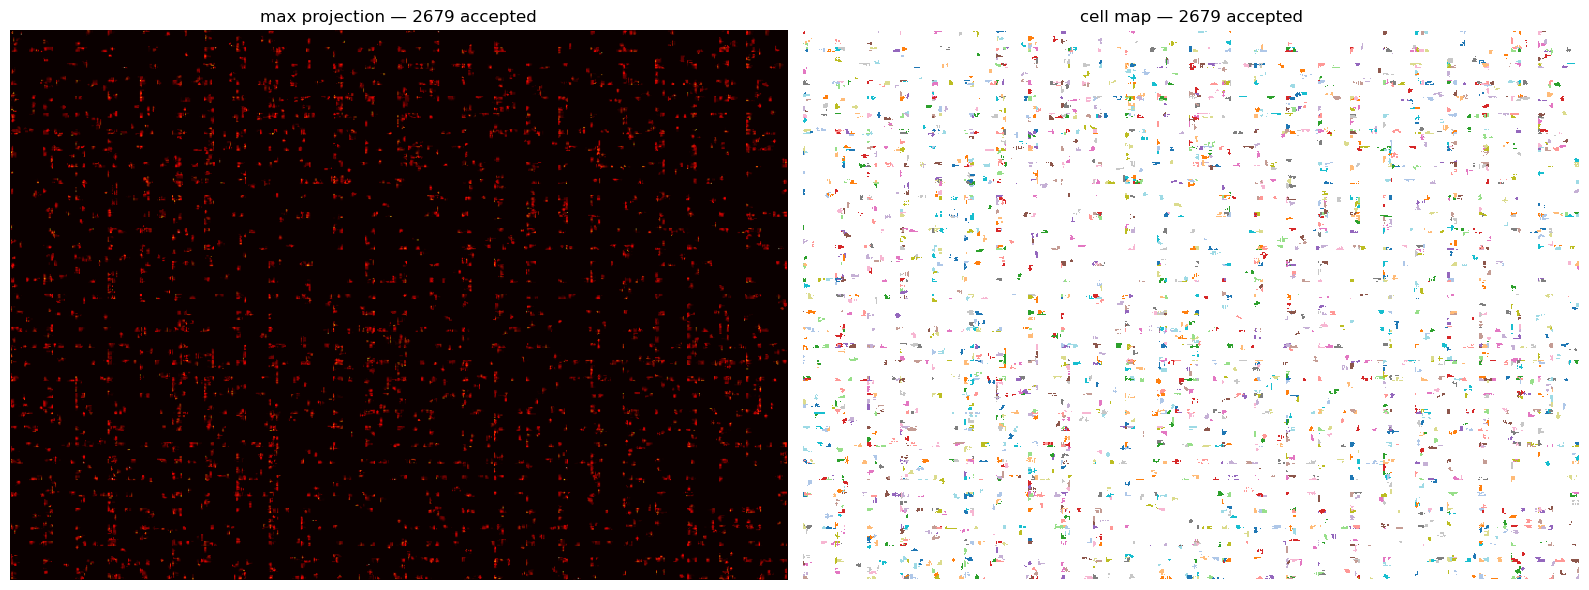

Coverage: 51223 / 726450 pixels (7.1%)


In [61]:
# strict AND filtering: component must pass ALL criteria
# caiman's built-in uses OR logic (good rval OR good SNR → accept)
# this uses AND logic (good rval AND good SNR AND good size → accept)

dx = meta["dx"]  # µm per pixel
mn_um, mx_um = 5, 25
mn_px = np.pi * (mn_um / (2 * dx)) ** 2
mx_px = np.pi * (mx_um / (2 * dx)) ** 2

# component sizes from sparse A
sizes = np.array((A > 0).sum(axis=0)).ravel()

# thresholds — adjust these to taste
rval_min = 0.2
snr_min = 0.8

good = (
    (est.r_values >= rval_min) &
    (est.SNR_comp >= snr_min) &
    (sizes >= mn_px) &
    (sizes <= mx_px)
)
idx_good = np.where(good)[0]
n_pixels = Ly * Lx

print(f"Pixel size: {dx:.2f} µm/px")
print(f"Size filter: {mn_um}-{mx_um} µm → {mn_px:.0f}-{mx_px:.0f} px")
print(f"rval_min={rval_min}, snr_min={snr_min}")
print(f"\nAND filtering: {A.shape[1]} → {len(idx_good)} components")
print(f"  pass rval >= {rval_min}: {(est.r_values >= rval_min).sum()}")
print(f"  pass SNR  >= {snr_min}:  {(est.SNR_comp >= snr_min).sum()}")
print(f"  pass size {mn_px:.0f}-{mx_px:.0f} px: {((sizes >= mn_px) & (sizes <= mx_px)).sum()}")
print(f"  pass ALL:         {len(idx_good)}")

# visualize
A_good = A[:, idx_good]
footprint = np.array(A_good.max(axis=1).todense()).ravel().reshape((Ly, Lx), order="F")
comp_ids = np.array(A_good.argmax(axis=1)).ravel().reshape((Ly, Lx), order="F")
mask = footprint > 0
cell_map = np.where(mask, comp_ids % 20, np.nan)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(footprint, cmap="hot", aspect="auto")
axes[0].set_title(f"max projection — {len(idx_good)} accepted")
axes[0].axis("off")
axes[1].imshow(cell_map, cmap="tab20", aspect="auto", interpolation="nearest")
axes[1].set_title(f"cell map — {len(idx_good)} accepted")
axes[1].axis("off")
plt.tight_layout()
plt.show()
print(f"Coverage: {mask.sum()} / {n_pixels} pixels ({100*mask.sum()/n_pixels:.1f}%)")

## 7. Evaluation Metrics

In [ ]:
# histograms with AND thresholds
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].hist(est.r_values, bins=100, color="gray", alpha=0.7)
axes[0].axvline(rval_min, color="r", ls="--", label=f"rval_min={rval_min}")
axes[0].set_xlabel("r_values (spatial correlation)")
axes[0].set_title("r_values distribution")
axes[0].legend()

axes[1].hist(np.clip(est.SNR_comp, 0, 30), bins=100, color="gray", alpha=0.7)
axes[1].axvline(snr_min, color="r", ls="--", label=f"snr_min={snr_min}")
axes[1].set_xlabel("SNR_comp")
axes[1].set_title("SNR distribution")
axes[1].legend()

axes[2].hist(sizes, bins=100, range=(0, 500), color="gray", alpha=0.7)
axes[2].axvline(mn_px, color="r", ls="--", label=f"mn={mn_um}µm={mn_px:.0f}px")
axes[2].axvline(mx_px, color="r", ls="--", label=f"mx={mx_um}µm={mx_px:.0f}px")
axes[2].set_xlabel("component size (pixels)")
axes[2].set_title("size distribution")
axes[2].legend()

plt.tight_layout()
plt.show()